In [1]:
# --- Imports & data loading ---
import pandas as pd
from pathlib import Path

base = Path("/Users/haozhangao/Desktop/RecSys Research/KuaiRec 2.0/data/prepared")

# residuals (empirical - policy) at the (user, session, category) level
resid = pd.read_csv(base / "D5D9_session_category_residuals.csv")

# demand estimates
params = pd.read_parquet(base / "b1_user_params.parquet")  # contains mu_hat, sigma, etc.
tau   = pd.read_parquet(base / "b1_user_tau.parquet")     # session-level tau estimates
c  = pd.read_parquet(base / "b1_user_c.parquet")       # user-level c_hat

# quick peek
for name, df in {"resid":resid, "params":params, "taus":tau, "c_tbl":c}.items():
    print(name, df.shape)
    print(df.head(3), "\n")


resid (2973200, 8)
   user_id  session i_top_category_id     q_emp  p_policy  residual  day_idx  \
0     2467        1              -124  0.000041  0.000000  0.000041        4   
1     2467        1                 1  0.032909  0.024691  0.008217        4   
2     2467        1                10  0.024692  0.000000  0.024692        4   

          day  
0  2020-07-08  
1  2020-07-08  
2  2020-07-08   

params (208728, 7)
   user_id category   seen   kept    mu_hat     sigma  exposures_total
0        0        1   True   True  0.442689  0.974833              7.0
1        0        2   True  False  0.000000  0.636010              2.0
2        0        3  False  False  0.000000  0.100000              0.0 

taus (68954, 5)
   user_id  session       tau  total_exposures  total_completions
0        0       11 -0.092598             14.0                9.0
1        0       12 -0.082050             31.0               19.0
2        0       13 -0.075322             22.0               11.0 

c_tbl (

In [2]:
import numpy as np
import pandas as pd

# --- tiny helpers: moments under a categorical mix over per-category Normal(μ_k, σ_k^2) ---
def mean_utility(p, mu):
    p = np.asarray(p, float)
    mu = np.asarray(mu, float)
    s = p.sum()
    if s <= 0:
        return np.nan
    p = p / s
    return float(p @ mu)

def var_utility(p, mu, sigma):
    p = np.asarray(p, float)
    mu = np.asarray(mu, float)
    sigma = np.asarray(sigma, float)

    s = p.sum()
    if s <= 0:
        return np.nan
    p = p / s

    m = p @ mu                              # mixture mean
    second_moment = p @ (mu**2 + sigma**2)  # E[u^2] for a Gaussian mixture
    return float(second_moment - m**2)

# ========== 1) Align categories ==========
params = params.copy()
params["category"] = params["category"].astype(str)

resid = resid.copy()
resid["i_top_category_id"] = resid["i_top_category_id"].astype(str)

# fixed category universe from params (you can change to union if needed)
cats = sorted(params["category"].unique())

# ========== 2) Per-user μ, σ over the fixed category set ==========
user_mu = (
    params.set_index(["user_id", "category"])["mu_hat"]
          .unstack("category")
          .reindex(columns=cats, fill_value=0.0)
)
user_sigma = (
    params.set_index(["user_id", "category"])["sigma"]
          .unstack("category")
          .reindex(columns=cats, fill_value=0.10)
)

# ========== 3) Build empirical/policy distributions (wide by category) ==========
# Expecting columns in resid: user_id, session, i_top_category_id, q_emp, p_policy
q_emp_wide = (
    resid.pivot_table(index=["user_id", "session"],
                      columns="i_top_category_id",
                      values="q_emp",
                      aggfunc="sum",
                      fill_value=0.0)
         .reindex(columns=cats, fill_value=0.0)
)
p_pol_wide = (
    resid.pivot_table(index=["user_id", "session"],
                      columns="i_top_category_id",
                      values="p_policy",
                      aggfunc="sum",
                      fill_value=0.0)
         .reindex(columns=cats, fill_value=0.0)
)

# keep only sessions that appear in tau
tau_keys = tau[["user_id", "session"]].drop_duplicates().set_index(["user_id", "session"]).index
have_both = q_emp_wide.index.intersection(p_pol_wide.index).intersection(tau_keys)

q_emp_wide = q_emp_wide.loc[have_both]
p_pol_wide = p_pol_wide.loc[have_both]

# ========== 4) Compute session-level Δ mean & Δ variance for ALL sessions in tau ==========
rows = []
for (uid, sess) in have_both:
    # distributions (normalize defensively)
    p_emp = q_emp_wide.loc[(uid, sess)].to_numpy(dtype=float)
    p_pol = p_pol_wide.loc[(uid, sess)].to_numpy(dtype=float)
    se_emp = p_emp.sum(); se_pol = p_pol.sum()
    if se_emp > 0: p_emp = p_emp / se_emp
    if se_pol > 0: p_pol = p_pol / se_pol

    # user parameters
    if uid not in user_mu.index:
        # skip if we don't have μ/σ for this user
        continue
    mu_u = user_mu.loc[uid].to_numpy(dtype=float)
    sg_u = user_sigma.loc[uid].to_numpy(dtype=float)

    # moments
    m_emp = mean_utility(p_emp, mu_u)
    m_pol = mean_utility(p_pol, mu_u)
    v_emp = var_utility(p_emp, mu_u, sg_u)
    v_pol = var_utility(p_pol, mu_u, sg_u)

    rows.append({
        "user_id": uid,
        "session": sess,
        "mean_empirical": m_emp,
        "mean_policy": m_pol,
        "delta_mean": m_emp - m_pol,
        "var_empirical": v_emp,
        "var_policy": v_pol,
        "delta_var": v_emp - v_pol,
    })

utility_change_df = (
    pd.DataFrame(rows)
      .sort_values(["user_id", "session"])
      .reset_index(drop=True)
)

# quick peek
utility_change_df.head()

,user_id,session,mean_empirical,mean_policy,delta_mean,var_empirical,var_policy,delta_var
0,0,11,0.159936,0.325938,-0.166002,0.743656,1.509497,-0.765841
1,0,12,0.011319,0.330166,-0.318847,1.170039,1.249027,-0.078988
2,0,13,0.061418,0.341785,-0.280367,1.107356,0.912791,0.194565
3,0,14,-0.020127,0.295264,-0.315391,0.777364,1.006062,-0.228698
4,0,15,0.142812,0.295264,-0.152452,0.648918,1.006062,-0.357144


In [3]:
import pandas as pd

# Ensure consistent dtypes
tau_use = tau[["user_id", "session", "tau"]].copy()
tau_use["user_id"] = tau_use["user_id"].astype(int)
tau_use["session"] = tau_use["session"].astype(int)

util = utility_change_df.copy()
util["user_id"] = util["user_id"].astype(int)
util["session"] = util["session"].astype(int)

# Build "previous-session" features by shifting session forward by +1
# so they align with the current session on merge
lag_cols = [
    "mean_empirical", "mean_policy", "delta_mean",
    "var_empirical", "var_policy", "delta_var"
]
util_prev = util[["user_id", "session"] + lag_cols].copy()
util_prev["session"] = util_prev["session"] + 1  # now each row describes previous session for this (user, session)

# Rename columns to indicate they come from the previous session
util_prev = util_prev.rename(columns={c: f"{c}_prev" for c in lag_cols})

# Merge: keep only sessions that have a previous-session record
reg_df = (
    tau_use.merge(util_prev, on=["user_id", "session"], how="inner")
           .sort_values(["user_id", "session"])
           .reset_index(drop=True)
)

print(reg_df.head(10).to_string(index=False))
print("\nRows:", len(reg_df))


 user_id  session       tau  mean_empirical_prev  mean_policy_prev  delta_mean_prev  var_empirical_prev  var_policy_prev  delta_var_prev
       0       12 -0.082050             0.159936          0.325938        -0.166002            0.743656         1.509497       -0.765841
       0       13 -0.075322             0.011319          0.330166        -0.318847            1.170039         1.249027       -0.078988
       0       14 -0.068509             0.061418          0.341785        -0.280367            1.107356         0.912791        0.194565
       0       15 -0.071854            -0.020127          0.295264        -0.315391            0.777364         1.006062       -0.228698
       0       16 -0.071816             0.142812          0.295264        -0.152452            0.648918         1.006062       -0.357144
       0       17 -0.068272             0.103024          0.409766        -0.306742            0.784467         1.208312       -0.423844
       0       18 -0.071373             0

In [4]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

df = reg_df.copy()

# Keep rows with complete lagged info
needed = ["user_id", "tau",
          "mean_empirical_prev", "var_empirical_prev",
          "delta_mean_prev", "delta_var_prev"]
df = df.dropna(subset=needed)

# Regression
formula = (
    "tau ~ delta_mean_prev + delta_var_prev + "
    "mean_empirical_prev + var_empirical_prev"
)

model = smf.ols(formula=formula, data=df)
res = model.fit(cov_type="cluster", cov_kwds={"groups": df["user_id"]})

print(res.summary())

# Tidy key coefficients
tbl = (pd.DataFrame({
    "coef": res.params,
    "se (clustered)": res.bse,
    "t": res.tvalues,
    "pval": res.pvalues
})
.loc[["delta_mean_prev", "delta_var_prev", "mean_empirical_prev", "var_empirical_prev"]]
.round(4))

print("\nKey coefficients (clustered by user_id):")
print(tbl.to_string())


                            OLS Regression Results                            
Dep. Variable:                    tau   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     10.83
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           9.57e-09
Time:                        00:29:56   Log-Likelihood:                -61540.
No. Observations:               51880   AIC:                         1.231e+05
Df Residuals:                   51875   BIC:                         1.231e+05
Df Model:                           4                                         
Covariance Type:              cluster                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.2319    

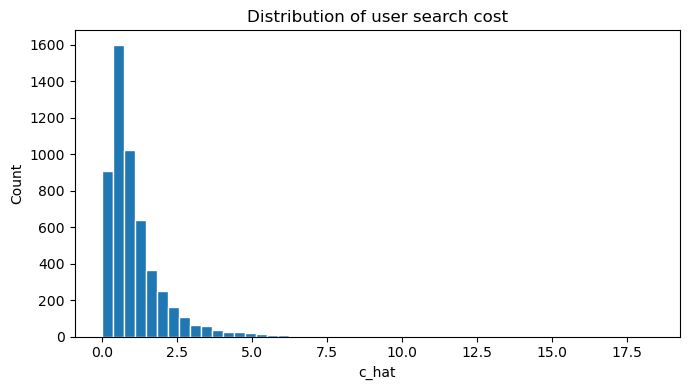

N         5352.0000
mean         1.1172
std          1.1345
min          0.0005
p10          0.2883
p25          0.4564
median       0.7913
p75          1.3539
p90          2.2604
max         18.3584
dtype: float64


In [10]:
# summary statistics of search cost

x = c['c_hat'].dropna().values

# --- 1) Histogram (linear scale) ---
plt.figure(figsize=(7,4))
plt.hist(x, bins=50, edgecolor='white')
plt.xlabel('c_hat'); plt.ylabel('Count'); plt.title('Distribution of user search cost')
plt.tight_layout(); plt.show()

# --- 2) Quick summary stats & percentiles ---
summary = pd.Series({
    'N': len(x),
    'mean': x.mean(),
    'std': x.std(ddof=1),
    'min': x.min(),
    'p10': np.percentile(x, 10),
    'p25': np.percentile(x, 25),
    'median': np.median(x),
    'p75': np.percentile(x, 75),
    'p90': np.percentile(x, 90),
    'max': x.max(),
})
print(summary.round(4))
